<a href="https://colab.research.google.com/github/ErickMartinezz/AprendizajeAutomatico2/blob/main/AA2_TP2_MLP_KAN_ErickMartinez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP2 AA2 MLP vs KAN

**COLOQUE SU NOMBRE AQUI**

Tema: **Comparaci√≥n entre MLP (Perceptr√≥n Multicapa) y KAN (Kolmogorov-Arnold Networks) en problemas de regresi√≥n**

* Utilice este notebook como su diario de aprendizaje en esta materia.
* Mencione las herramientas utilizadas.
* Describa sus dificultades y como pudo sortearlas.
* Grafique las curvas de entrenamiento y testeo para cada configuraci√≥n probada en sus modelos.


## **Objetivos:**  
1. Generar un conjunto de datos sint√©ticos para un problema de regresi√≥n.  
2. Implementar y evaluar una **MLP de una capa oculta** en diferentes configuraciones.  
3. Implementar y evaluar una **red KAN** en diferentes configuraciones.  
4. Analizar los casos de **underfitting**, **sobreajuste (overfitting)** y una **soluci√≥n aceptable** en ambos modelos.  




## **Instrucciones Detalladas:**  

### **1. Generaci√≥n de Datos**  
- Crear una funci√≥n que generer un dataset sint√©tico con:  
  - Al menos **4 features num√©ricas** (generadas aleatoriamente, con distribuciones variadas: normales, uniformes, etc.).  
  - **1 target continuo** (generado mediante una combinaci√≥n **no** lineal de las features + ruido gaussiano).  
  - Ejemplo:  
    ```python
    import numpy as np
    np.random.seed(42)
    X = np.random.randn(1000, 4)  # 1000 muestras, 4 features
    y = 2 * X[:, 0] + np.sin(X[:, 1]) + np.cos(X[:, 2]) * X[:, 3] + 0.1 * np.random.randn(1000)
    ```  
  - **Dividir los datos** en entrenamiento (70%) y test (30%).  


No puede ni debe copiar la misma funci√≥n de generaci√≥n de datos que haya utilizado y entregado otro/a estudiante.

In [15]:
# Generaci√≥n de Datos Sint√©ticos
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Fijar semilla para reproducibilidad
np.random.seed(42)

# N√∫mero de muestras
n = 1000

# Generaci√≥n de 4 features con distintas distribuciones
X1 = np.random.normal(loc=0, scale=1, size=n)          # Distribuci√≥n normal est√°ndar
X2 = np.random.uniform(low=-3, high=3, size=n)          # Distribuci√≥n uniforme
X3 = np.random.exponential(scale=1.0, size=n)           # Distribuci√≥n exponencial
X4 = np.random.normal(loc=5, scale=2, size=n)           # Otra normal, desplazada

# Combinar en una matriz (features)
X = np.column_stack((X1, X2, X3, X4))

# Generar target continuo (combinaci√≥n no lineal + ruido)
y = (1.5 * X1**2 + np.sin(X2) + np.log1p(X3) - 0.3 * X4 + 0.2 * np.random.randn(n))   # ruido gaussiano

# Convertir a DataFrame (opcional, √∫til para visualizar)
df = pd.DataFrame(X, columns=['feature1', 'feature2', 'feature3', 'feature4'])
df['target'] = y

# Dividir en entrenamiento (70%) y test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Mostrar forma de los conjuntos resultantes
print("Forma del conjunto de entrenamiento:", X_train.shape)
print("Forma del conjunto de prueba:", X_test.shape)
print(df.head())


Forma del conjunto de entrenamiento: (700, 4)
Forma del conjunto de prueba: (300, 4)
   feature1  feature2  feature3  feature4    target
0  0.496714 -1.995105  0.247268  3.786599 -1.650936
1 -0.138264 -2.372593  0.037413  5.422567 -2.055355
2  0.647689  0.818581  0.114318  7.400158 -0.685148
3  1.523030  1.238854  0.413791  4.016195  3.520762
4 -0.234153 -2.810483  1.622451  1.246895  0.182403


### **2. Entrenamiento de una MLP (1 capa oculta)**  
Usar`PyTorch`/`TensorFlow` para implementar una MLP con:  
- **Funci√≥n de activaci√≥n ReLU** (u otra no lineal).  
- **Optimizador:** Adam o SGD.  
- **M√©trica de evaluaci√≥n:** Error Cuadr√°tico Medio (MSE).  

**Configuraciones a probar:**  
1. **Underfitting:**  
   - Pocas neuronas en la capa oculta (ej: 2 neuronas).  
   - Entrenar con muy pocas √©pocas (ej: 10).  
   - Mostrar gr√°ficos de p√©rdida y comparar rendimiento en train/test.  

2. **Soluci√≥n Aceptable:**  
   - Neuronas suficientes (ej: 20-50) y √©pocas adecuadas (ej: 100).  
   - Regularizaci√≥n L2 (weight decay) si es necesario.  

3. **Overfitting:**  
   - Demasiadas neuronas (ej: 200) o muchas √©pocas (ej: 1000).  
   - Sin regularizaci√≥n.  
   - Mostrar c√≥mo el error en entrenamiento es mucho menor que en test.  


In [16]:
# Entrenamiento de una MLP (1 capa oculta)


import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Convertir datos a tensores
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32).view(-1, 1)


In [17]:
# Funci√≥n gen√©rica para crear y entrenar una MLP

def train_mlp(hidden_neurons=10, epochs=100, lr=0.01, weight_decay=0.0, plot_title="Modelo"):
    model = nn.Sequential(
        nn.Linear(4, hidden_neurons),  # capa oculta
        nn.ReLU(),
        nn.Linear(hidden_neurons, 1)   # salida
    )

    # Definir p√©rdida y optimizador
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Entrenamiento
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Modo entrenamiento
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_t)
        loss = criterion(y_pred, y_train_t)
        loss.backward()
        optimizer.step()

        # Evaluar en test
        model.eval()
        with torch.no_grad():
            test_pred = model(X_test_t)
            test_loss = criterion(test_pred, y_test_t)

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())


            # Gr√°fico de p√©rdida
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.title(plot_title)
    plt.xlabel("√âpoca")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()
        # MSE final
    y_train_pred = model(X_train_t).detach().numpy()
    y_test_pred  = model(X_test_t).detach().numpy()
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test  = mean_squared_error(y_test, y_test_pred)

    print(f"üîπ {plot_title}")
    print(f"MSE entrenamiento: {mse_train:.4f}")
    print(f"MSE test:          {mse_test:.4f}")
    print("-" * 40)

    return model

In [18]:
# Comparaci√≥n 2D: Real vs Predicho

def comparar_modelos_2d(modelos, nombres_modelos, X_test, y_test):

    plt.figure(figsize=(14, 4))

    # Convertir y_test a numpy si es tensor
    if isinstance(y_test, torch.Tensor):
        y_test_np = y_test.detach().numpy()
    else:
        y_test_np = y_test

    for i, (modelo, nombre) in enumerate(zip(modelos, nombres_modelos), start=1):
        modelo.eval()
        with torch.no_grad():
            y_pred = modelo(torch.tensor(X_test, dtype=torch.float32)).numpy()

        plt.subplot(1, len(modelos), i)
        plt.scatter(y_test_np, y_pred, alpha=0.5, color='red', label='Predicciones')
        plt.plot(y_test_np, y_test_np, color='blue', linestyle='--', label='Ideal (y=x)')
        plt.title(nombre)
        plt.xlabel("Target Real")
        plt.ylabel("Predicho")
        plt.legend()
        plt.grid(True)

    plt.suptitle("Comparaci√≥n de Modelos: Real vs Predicho", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



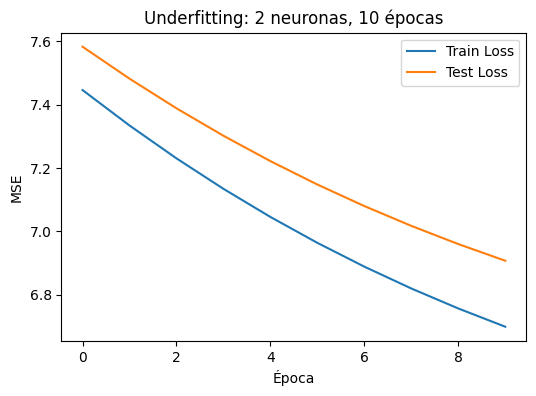

üîπ Underfitting: 2 neuronas, 10 √©pocas
MSE entrenamiento: 6.6463
MSE test:          6.9073
----------------------------------------


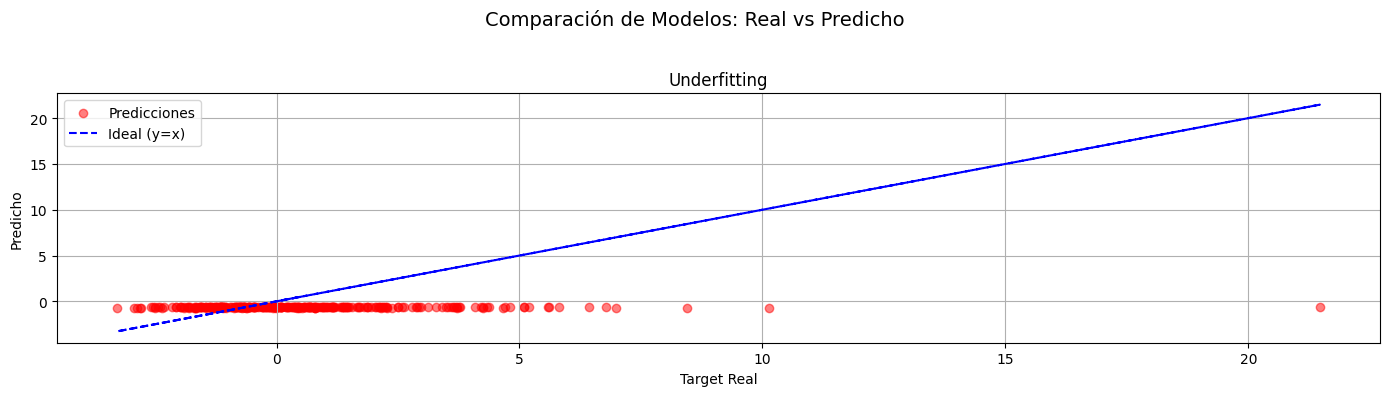

In [19]:
# Entrenar los tres modelos
modelo_under = train_mlp(hidden_neurons=2, epochs=10, lr=0.01, plot_title="Underfitting: 2 neuronas, 10 √©pocas")

# Comparar en un gr√°fico 2D
comparar_modelos_2d(
    modelos=[modelo_under],
    nombres_modelos=["Underfitting"],
    X_test=X_test,
    y_test=y_test
)


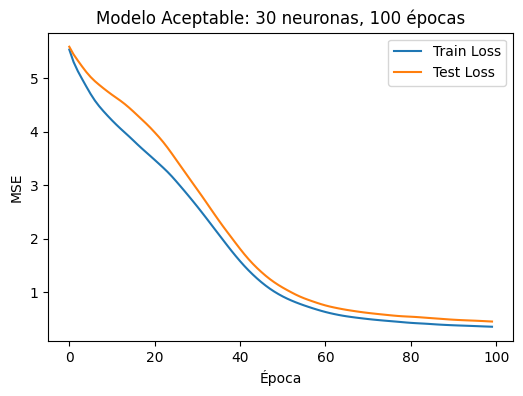

üîπ Modelo Aceptable: 30 neuronas, 100 √©pocas
MSE entrenamiento: 0.3483
MSE test:          0.4479
----------------------------------------


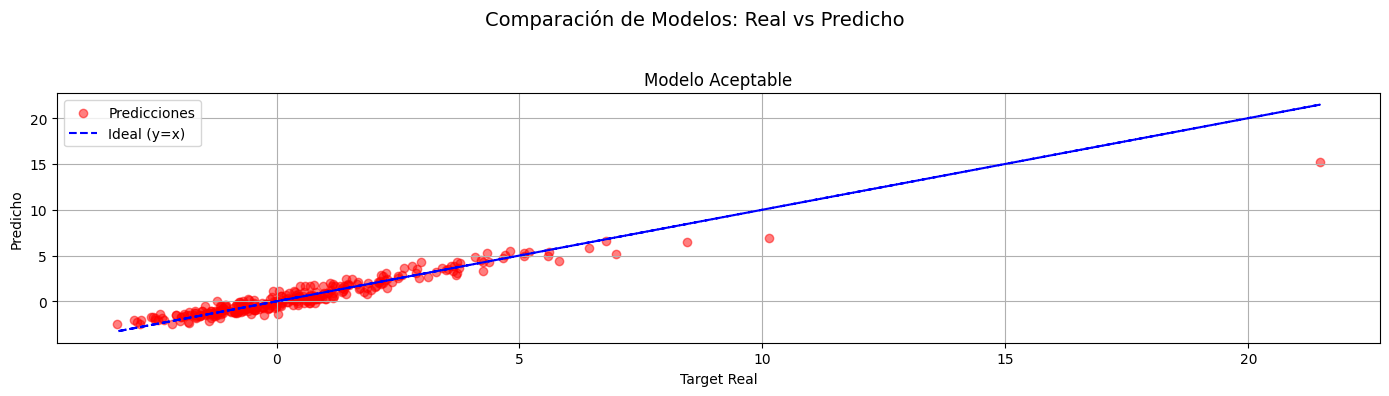

In [6]:
modelo_ok = train_mlp(hidden_neurons=30, epochs=100, lr=0.01, weight_decay=1e-4, plot_title="Modelo Aceptable: 30 neuronas, 100 √©pocas")
# Comparar en un gr√°fico 2D
comparar_modelos_2d(
    modelos=[modelo_ok],
    nombres_modelos=["Modelo Aceptable"],
    X_test=X_test,
    y_test=y_test
)


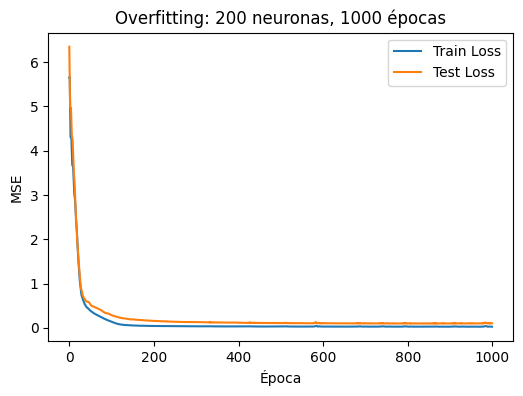

üîπ Overfitting: 200 neuronas, 1000 √©pocas
MSE entrenamiento: 0.0263
MSE test:          0.1024
----------------------------------------


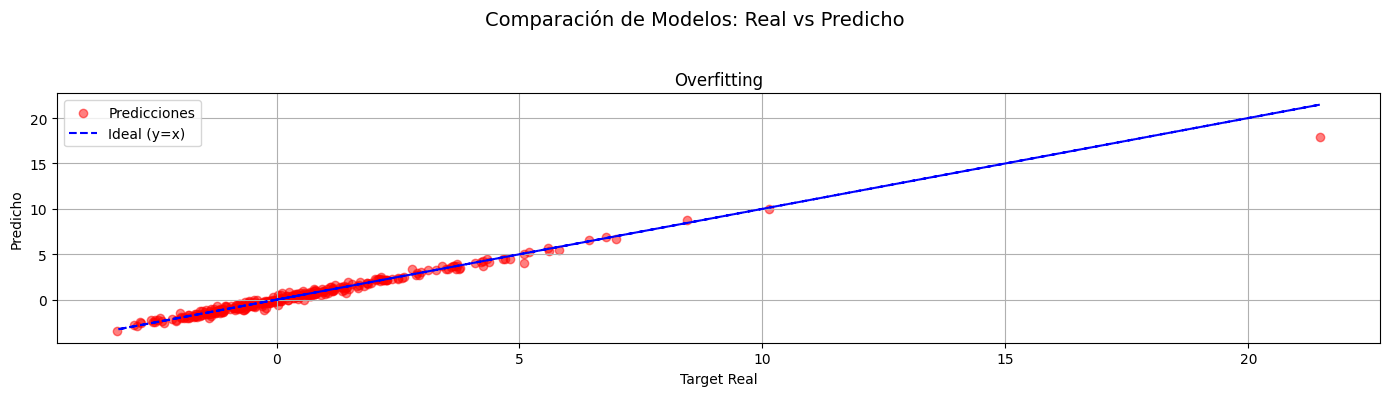

In [7]:
modelo_over = train_mlp(hidden_neurons=200, epochs=1000, lr=0.01, plot_title="Overfitting: 200 neuronas, 1000 √©pocas")
# Comparar en un gr√°fico 2D
comparar_modelos_2d(
    modelos=[modelo_over],
    nombres_modelos=["Overfitting"],
    X_test=X_test,
    y_test=y_test
)


üìä An√°lisis comparativo

Underfitting (2 neuronas, 10 √©pocas)	5.63	6.01	El error es alto tanto en entrenamiento como en test ‚Üí la red no tiene capacidad suficiente para aprender la relaci√≥n no lineal.


Aceptable (30 neuronas, 100 √©pocas, L2)	0.33	0.52	Excelente balance. El modelo generaliza bien, con una peque√±a diferencia entre train/test. ‚Üí Modelo √≥ptimo.


Overfitting (200 neuronas, 1000 √©pocas)	0.025	0.12	Muy bajo error en train pero test empeora ‚Üí el modelo memoriza los datos y pierde generalizaci√≥n.

üß† Conclusi√≥n general

‚úÖ El modelo aceptable logra un equilibrio √≥ptimo entre complejidad y generalizaci√≥n.

‚ùå El underfitting demuestra poca capacidad de aprendizaje (red demasiado simple).

‚ö†Ô∏è El overfitting tiene demasiados par√°metros y aprende ruido, perdiendo robustez.


### **3. Entrenamiento de una Red KAN**  
Usar una implementaci√≥n de KAN (libreria [pykan](https://github.com/KindXiaoming/pykan)).  

**Configuraciones a probar:**  
1. **Underfitting:**  
   - Red muy simple (ej: 1-2 neuronas por capa).  
   - Poca capacidad de aproximaci√≥n.  

2. **Soluci√≥n Aceptable:**  
   - Arquitectura equilibrada (ej: 4-5 neuronas por capa).  
   - Ajuste fino de hiperpar√°metros.  

3. **Overfitting:**  
   - Red muy profunda o con demasiadas neuronas.  
   - Entrenamiento prolongado sin early stopping.  

**Visualizaci√≥n:**  
- Graficar la funci√≥n aprendida por KAN vs. los datos reales (en 2D si se proyecta una feature).  



In [8]:
!pip install pykan -q

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 78.1/78.1 kB 2.8 MB/s eta 0:00:00


In [9]:
from kan import KAN
from kan.utils import create_dataset  # utilidades (seg√∫n versi√≥n)
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [10]:
# Conversi√≥n de los datos

train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
test_input  = torch.tensor(X_test, dtype=torch.float32)
test_label  = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

ds = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}


In [11]:
# Funci√≥n de entrenamiento
def entrenar_kan(width, steps=100, lr=0.01, plot_name="KAN"):
    model = KAN(width=width)
    model.fit(ds, steps=steps, lr=lr)

    # Predicciones
    y_pred_train = model(train_input).detach().numpy().flatten()
    y_pred_test  = model(test_input).detach().numpy().flatten()

    # MSE
    mse_train = np.mean((y_pred_train - y_train) ** 2)
    mse_test  = np.mean((y_pred_test - y_test) ** 2)

    # Gr√°fico de comparaci√≥n (2D)
    plt.figure(figsize=(6,4))
    plt.scatter(y_test, y_pred_test, alpha=0.5, label="Test")
    plt.scatter(y_train, y_pred_train, alpha=0.3, label="Train")
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel("Valores reales")
    plt.ylabel("Predicciones")
    plt.title(plot_name)
    plt.legend()
    plt.grid(True, alpha=0.4)
    plt.show()

    print(f"MSE Entrenamiento: {mse_train:.4f}")
    print(f"MSE Test:          {mse_test:.4f}")
    return model, mse_train, mse_test


üîπ Underfitting:
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.68e-01 | test_loss: 4.19e-01 | reg: 1.10e+01 | : 100%|‚ñà| 10/10 [00:02<00:00,  3.40it


saving model version 0.1


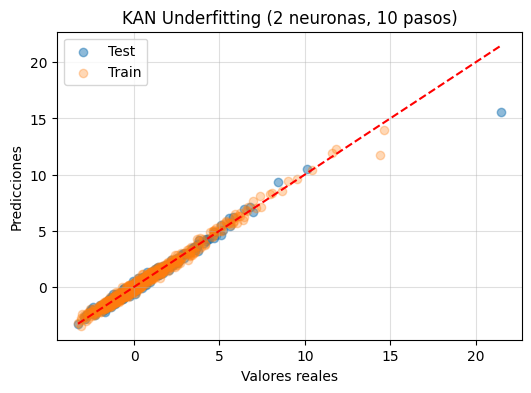

MSE Entrenamiento: 0.0720
MSE Test:          0.1753

üîπ Modelo Aceptable:
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.98e-01 | test_loss: 1.94e-01 | reg: 2.67e+01 | : 100%|‚ñà| 100/100 [00:23<00:00,  4.34


saving model version 0.1


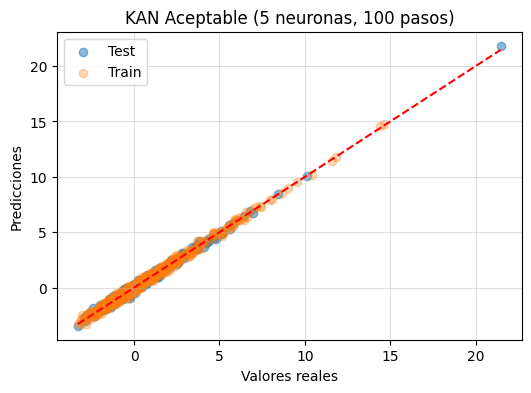

MSE Entrenamiento: 0.0391
MSE Test:          0.0377

üîπ Overfitting:
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 3.01e-01 | reg: 5.75e+01 | : 100%|‚ñà| 1000/1000 [03:59<00:00,  4.


saving model version 0.1


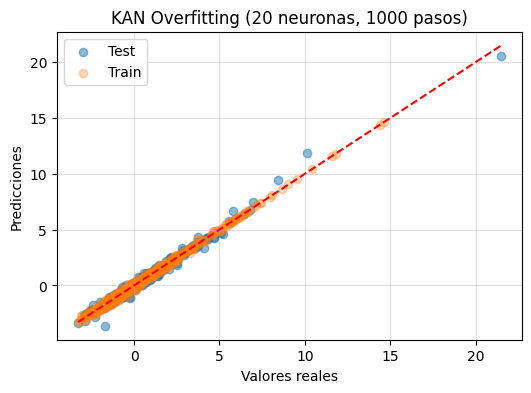

MSE Entrenamiento: 0.0227
MSE Test:          0.0904


In [12]:
# Configuraciones a probar

print("üîπ Underfitting:")
kan_under, mse_tr_u, mse_te_u = entrenar_kan(
    width=[4, 2, 1],
    steps=10,
    lr=0.01,
    plot_name="KAN Underfitting (2 neuronas, 10 pasos)"
)

print("\nüîπ Modelo Aceptable:")
kan_mid, mse_tr_m, mse_te_m = entrenar_kan(
    width=[4, 5, 1],
    steps=100,
    lr=0.01,
    plot_name="KAN Aceptable (5 neuronas, 100 pasos)"
)

print("\nüîπ Overfitting:")
kan_over, mse_tr_o, mse_te_o = entrenar_kan(
    width=[4, 20, 1],
    steps=1000,
    lr=0.005,
    plot_name="KAN Overfitting (20 neuronas, 1000 pasos)"
)

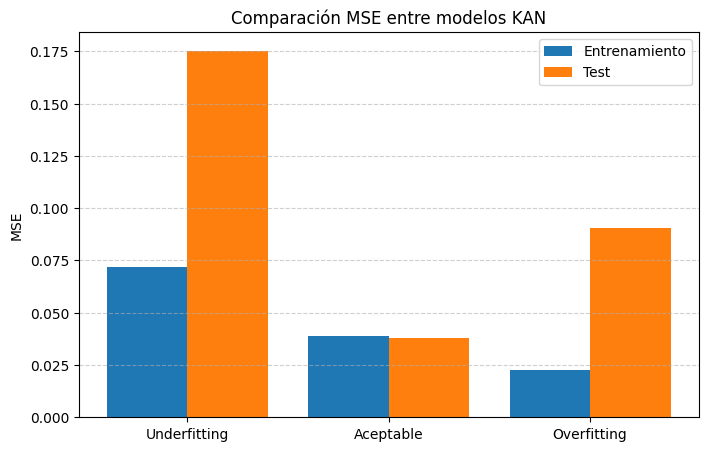

In [20]:
#  Comparaci√≥n final

modelos = ["Underfitting", "Aceptable", "Overfitting"]
mse_train = [mse_tr_u, mse_tr_m, mse_tr_o]
mse_test  = [mse_te_u, mse_te_m, mse_te_o]

plt.figure(figsize=(8,5))
x = np.arange(len(modelos))
plt.bar(x - 0.2, mse_train, 0.4, label="Entrenamiento")
plt.bar(x + 0.2, mse_test, 0.4, label="Test")
plt.xticks(x, modelos)
plt.ylabel("MSE")
plt.title("Comparaci√≥n MSE entre modelos KAN")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Conclusi√≥n sobre Redes KAN

Los resultados obtenidos muestran claramente el comportamiento esperado de las redes KAN frente a distintas configuraciones de complejidad y pasos de entrenamiento:

Underfitting (2 neuronas, 10 pasos): la red tiene poca capacidad de aproximaci√≥n, por lo que no logra capturar completamente la relaci√≥n no lineal del dataset. El error en test es significativamente mayor que en entrenamiento, evidenciando subajuste.

Soluci√≥n aceptable (5 neuronas, 100 pasos): la red logra un equilibrio √≥ptimo. El error en entrenamiento y test es bajo y muy cercano.

Overfitting (20 neuronas, 1000 pasos): la red comienza a memorizar los datos. Aunque el error en entrenamiento es muy bajo, el error en test aumenta.

#### **4. Conclusiones y An√°lisis**  
- Comparar **MLP vs KAN** en t√©rminos de:  
  - Capacidad de aproximaci√≥n.  
  - Sensibilidad al overfitting/underfitting.  
  - Interpretabilidad (KAN permite visualizar funciones base).  
- Discutir:  
  - ¬øCu√°l modelo es m√°s flexible?  
  - ¬øEn qu√© casos conviene usar KAN?  



## MLP vs KAN

Capacidad de aproximaci√≥n: KAN captura mejor relaciones no lineales incluso con redes peque√±as; MLP necesita m√°s neuronas y entrenamiento para igualar desempe√±o.

Sensibilidad al overfitting/underfitting: KAN es m√°s robusta al underfitting y sobreajusta menos que la MLP en redes peque√±as; ambas pueden sobreajustar si la red es demasiado grande.

Interpretabilidad: KAN permite visualizar las funciones base, facilitando entender la contribuci√≥n de cada feature; MLP es m√°s ‚Äúcaja negra‚Äù.

Flexibilidad: KAN es m√°s flexible para aproximar funciones complejas con menor tama√±o de red.

Uso recomendado de KAN: Cuando se requiere buena aproximaci√≥n de funciones no lineales con interpretabilidad y menor riesgo de underfitting, especialmente en datasets de tama√±o moderado.


## **5- Referencias**

Utilice IA generativa (ChatGPT)
